***Check version: 10 for notebook with AUC score 0.94. Here I've tried to implement a new ensemble method. More tuning is being performed currently to achieve a better result. You can have some idea about ensemble method in binary or multiclass classification from here if you want and some upvotes would really be appreciated if you get any help from here.That will keep me motivated. Thank you***

# Pneumonia Detection

**Pneumonia is an infection that inflames your lungs' air sacs (alveoli). The air sacs may fill up with fluid or pus, causing symptoms such as a cough, fever, chills and trouble breathing. Bacteria and viruses are the main causes of pneumonia. Pneumonia-causing germs can settle in the alveoli and multiply after a person breathes them in. Pneumonia can be contagious. The bacteria and viruses that cause pneumonia are usually inhaled.**

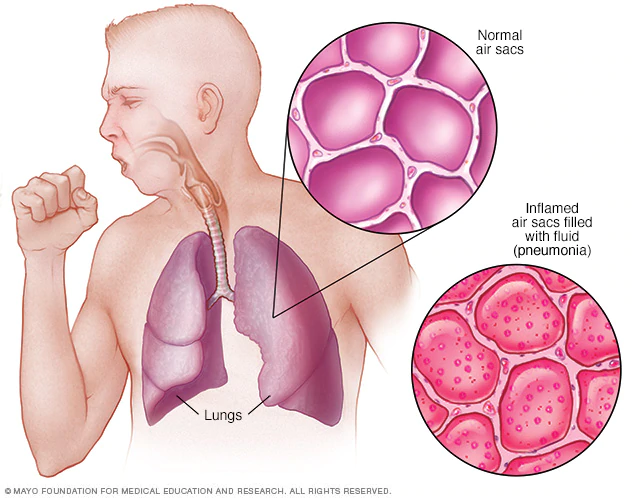

**A pneumonia infection is no joke. In fact, UNICEF reports that pneumonia kills more children than any other illness. Even if you combined the deal toll of AIDS, measles, and malaria, you would still not have a number high enough to match that of the deaths pneumonia has caused. This dangerous infection should not be taken lightly. It is good to be acquainted with the four stages of pneumonia. The sooner you recognize the illness, the better for your recovery.**
   1. Congestion: This stage occurs within the first 24 hours of contracting pneumonia. During congestion, the body will experience vascular engorgement, intra-alveolar fluid, and multiple bacteria. The lungs will be very heavy and red. Capillaries in the alveolar walls become congested and the infection will spread to the hilum and pleura. During this stage, a person will experience coughing and deep breathing. 
   
   2. Red Hepatization: This stage occurs two to three days after congestion. At this point, the lungs will be red, firm, and airless with a resemblance to the liver. Alveolar capillaries will be engorged with blood and vascular congestion will persist. During the red hepatization stage, the alveoli will contain many erythrocytes, neutrophils, desquamated epithelial cells, and fibrin.

   3. Grey Hepatization: This stage will occur two to three days after red hepatization and is an avascular stage. The lungs will appear to be a grayish brown or yellow color because of the disintegration of red cells. Your lungs will also appear to be paler and drier than usual. There will be a persistence of fibrin exudate during this stage.
   
   4. Resolution: The resolution, or complete recovery, occurs when the exudate experiences progressive enzymatic digestion. This will produce debris that is eventually reabsorbed, ingested by macrophages, coughed up, or reorganized by fibroblasts.
   
  
  Courtesy: [Four Stages of Pneumonia](http://www.bassadvancedurgentcare.com/post/four-stages-of-pneumonia)

# Introduction

**In this notebook, I tried to differentiate the Normal and Pneumonia affected patients using chest X-ray images using a Lightweight Convolutional Neural Network. As a beginner myself, I searched a lot to perform prediction with higher acccuracy but less number of parameters thus know the difficulties and misunderstanding in the way. That's why, Here I will try my best to explain every steps for the sake of better understanding. Hope this will help the beginners like me to learn the basic image classification using CNN.**

# Dataset Description

**The dataset was collected from the [Chest X-ray pneumonia dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia). It contains three folders named train (for training), val (for validation), and test (for testing). Each of them has two sub-folders with label "NORMAL" and "PENUMONIA".**

* train
     * NORMAL
     * PNEUMONIA


* val
     * NORMAL
     * PNEUMONIA
   
   
* test
     * NORMAL
     * PNEUMONIA

# Import Libraries

**First, we need to import the necessary libraries for this task.**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout,Dense, Flatten, BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D, Lambda, Input, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import itertools
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from itertools import cycle
from scipy import interp
from sklearn import metrics
#from imutils import paths
from keras.models import load_model
import os
import cv2
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

**Here, I have initialized the image width and height for efficient training. You can change it as per your will. Then the image dirctories of training and testing images were set. I skipped the val directory but you can use it for your validation task. The parameters can be tuned as per your desire.**

In [2]:
img_width, img_height = 64, 64
train_data_dir = '../input/chest-xray-pneumonia/chest_xray/train'
#validation_data_dir = '../input/binary-wbc/binary_data/val'
test_data_dir = '../input/chest-xray-pneumonia/chest_xray/test'
nb_train_samples = 5216
nb_validation_samples = 624
#epochs = 10
batch_size = 64

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Data Augmentation

**To perform the data augmentation, here the [ImageDataGenerator](https://keras.io/api/preprocessing/image/) class provided by Keras has been initialized. You can learn more about it from the provided link.**

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, #rescales each images (normalization)
    shear_range=0.2,  #shears each images by 0.2%
    zoom_range=0.2, # zoom each image by 0.2%
    width_shift_range=0.2,  #shifts width
    height_shift_range=0.2,  #shifts height
    horizontal_flip=False,  #horizontally flips the images
    vertical_flip=False)
test_datagen = ImageDataGenerator(rescale=1. / 255)  #no augmentation is performed for test set except for the normalization.


**Creates batches for training, validation and testing**

In [4]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    #classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    class_mode='categorical')  #class mode is set to binary as we are performing binary classification.

Found 5216 images belonging to 2 classes.


In [5]:
#valid_batches = test_datagen.flow_from_directory(
    #validation_data_dir,
    #target_size=(img_width, img_height),
    #batch_size=batch_size,
    #classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    #color_mode="grayscale")

In [6]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=624,
    #classes=['MONONUCLEAR', 'POLYNUCLEAR'])
    class_mode='categorical')   #class mode is set to binary as we are performing binary classification.

Found 624 images belonging to 2 classes.


# Model

**Now, the Convolutional Neural Network model is to be built. Here I have implemented a Sequential model with 7 layers (excluding output layer). The first 5 layers are convolutional layer and the last two are dense layers also known as fully connected layers. The number of filters in each layer is chosen through experimentation. You can try tuning the value for better result and clearer cocept. You can also add layers as per your need.**

**The convolutional(Conv) layers have parameters filters, kernel size, input shape, and padding. Kernel size value should be chosen carefully. If you need to extract very fine details, you should use a small kernel size and for larger features, larger kernel size should be chosen. There is no limitation of using same kernel size in each layer. It can vary. All you have to do is experiment.**

**Only for the first Conv layer, you need to define the input shape. The later layers take the previous layer's output as it's input. padding is used to add extra pixel values of zero to the image. One thing to note that *I got error initially while tried to add more number of layers. The dimensionality didn't match. Then switched the padding value from valid to same which solved my problem***

**I used the relu activation function in each layer except for the output layer, where i have used the sigmoid activation function for binary classification. The MaxPooling layer extracts the pixels with max values and use it for next steps. The Adam optimizer and binary crossentropy loss function is applied for training. The EarlyStopping monitors the training process and stops it when no more improvement occurs. The models are saved in the defined output directory from where i used the best model to perform prediction on test set.**



# Avoid Overfitting

**To avoid the famous over-fitting problem, I used the dropout regularization method. Dropout means it disables a percentage of neurons from extracting unneccessary features. You can add dropout layer after each conv layer with your needed value. You need to figure out which value suits your model better.**

In [14]:
epochs = 25
INIT_LR = 0.0001
opt = Adam(lr=INIT_LR, decay=INIT_LR / epochs)

In [15]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 5
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()
    model[j].add(BatchNormalization(input_shape=input_shape))
    model[j].add(Conv2D(32, (3, 3), padding='valid'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    #model[j].add(Dropout(0.4))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    model[j].add(Dropout(0.5))
    
    model[j].add(Conv2D(32, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Conv2D(64, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Conv2D(128, (5, 5), padding='same'))
    #model[j].add(BatchNormalization())
    model[j].add(Activation('relu'))
    model[j].add(MaxPooling2D(pool_size=(2, 2)))
    
    model[j].add(Flatten())
    #model[j].add(Dense(128))
    #model[j].add(Activation('relu'))
    model[j].add(Dense(256))
    model[j].add(Activation('relu'))
    model[j].add(Dropout(0.5))
    #model[j].add(Dense(32))
    #model[j].add(Activation('relu'))

    model[j].add(Dense(2))
    model[j].add(Activation('softmax'))
    model[j].summary()

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
activation_180 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 31, 31, 32)        25632     
_________________________________________________________________
activation_181 (Activation)  (None, 31, 31, 32)      

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_34 (Batc (None, 64, 64, 3)         12        
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
activation_204 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 31, 31, 32)        25632     
_________________________________________________________________
activation_205 (Activation)  (None, 31, 31, 32)      

In [16]:
# DECREASE LEARNING RATE EACH EPOCH
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
for j in range(nets):
    #X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(train_batches,
        epochs = epochs, steps_per_epoch = nb_train_samples // batch_size,
        validation_data = test_batches,
        validation_steps = nb_validation_samples // batch_size,
        callbacks=[#annealer,
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
        tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
        ])  #, callbacks=[annealer]
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

Epoch 1/25
81/81 [==============================] - 70s 865ms/step - loss: 0.5733 - accuracy: 0.7461 - val_loss: 0.6553 - val_accuracy: 0.6250
Epoch 2/25
81/81 [==============================] - 70s 869ms/step - loss: 0.4217 - accuracy: 0.8170 - val_loss: 0.5731 - val_accuracy: 0.6971
Epoch 3/25
81/81 [==============================] - 72s 883ms/step - loss: 0.3296 - accuracy: 0.8612 - val_loss: 0.4731 - val_accuracy: 0.8077
Epoch 4/25
81/81 [==============================] - 70s 870ms/step - loss: 0.2792 - accuracy: 0.8847 - val_loss: 0.4649 - val_accuracy: 0.8109
Epoch 5/25
81/81 [==============================] - 72s 884ms/step - loss: 0.2801 - accuracy: 0.8837 - val_loss: 0.4062 - val_accuracy: 0.8638
Epoch 6/25
81/81 [==============================] - 70s 870ms/step - loss: 0.2427 - accuracy: 0.8975 - val_loss: 0.4240 - val_accuracy: 0.8462
Epoch 7/25
81/81 [==============================] - 71s 879ms/step - loss: 0.2426 - accuracy: 0.9033 - val_loss: 0.4071 - val_accuracy: 0.8558

81/81 [==============================] - 64s 790ms/step - loss: 0.1899 - accuracy: 0.9262 - val_loss: 0.2976 - val_accuracy: 0.8702
Epoch 8/25
81/81 [==============================] - 65s 797ms/step - loss: 0.1946 - accuracy: 0.9194 - val_loss: 0.2997 - val_accuracy: 0.8702
CNN 5: Epochs=25, Train accuracy=0.92624, Validation accuracy=0.88301


In [17]:
test_imgs, test_labels = next(test_batches)

In [18]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (624,2) ) 
for j in range(nets):
    results = results + model[j].predict_generator(test_imgs, steps=1, verbose=0)
results = np.argmax(results,axis = -1)
#results = pd.Series(results,name="Label")
#submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
#submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

In [19]:
results

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,

In [20]:
test_labels = np.argmax(test_labels,axis = -1)
test_labels

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,

**Here I used a pre-trained model from previous version to perform the prediction. You can use any model you want from your training. The model I used (trained in the previous versions) outperforms all the recently trained models. You can modify your model and use the best performing model to perform the prediction after training the model. Just import the model in following way.**

In [20]:
#test_model = load_model('../input/acc-9330/model_0.933.h5')

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=results)

**Here the Accuracy is of the imported pre-trained model and the Train acc is of the recently trained model.**

In [22]:
acc = accuracy_score(test_labels, results)*100
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall: {0:0.2f}%'.format(recall))
print('F1-score: {0:0.2f}'.format(2*precision*recall/(precision+recall)))
#print('Train acc: {0:0.2f}'.format(np.round((h.history['accuracy'][-1])*100, 2)))

Accuracy: 89.58%
Precision: 92.88%
Recall: 90.26%
F1-score: 91.55


In [23]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[207  27]
 [ 38 352]]


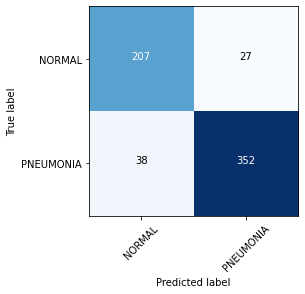

In [24]:
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [25]:
#confusion matrix-->correct identification = 202+380= 582
#                -->wrong identification = 32+10 = 42
#                --> accuracy = 582/(582 + 42) = 0.9326 or (93.26% accuracy)

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_true=test_labels, y_pred=results))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       234
           1       0.93      0.90      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


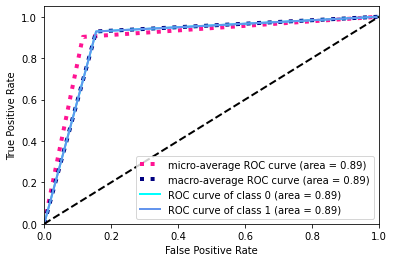

In [28]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(results,test_labels)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), results.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(2)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(2):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 2

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'cornflowerblue'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

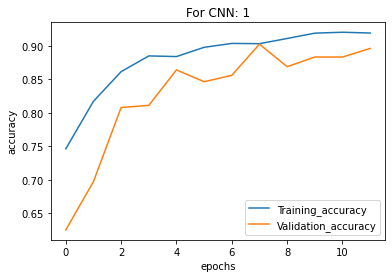

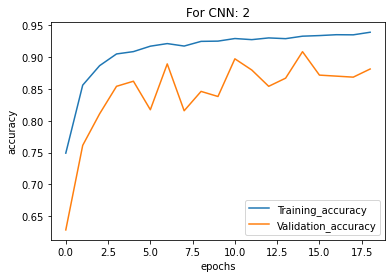

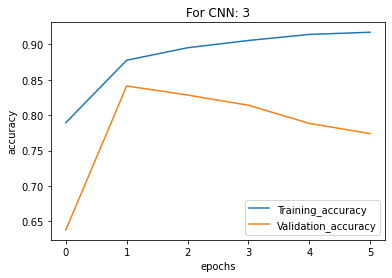

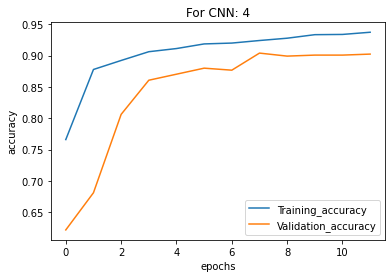

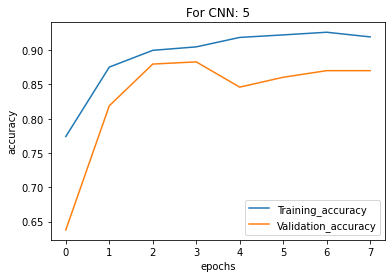

In [29]:
for j in range(nets):
    accs = history[j].history['accuracy']
    val_accs = history[j].history['val_accuracy']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
    plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

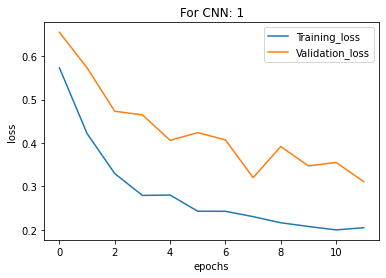

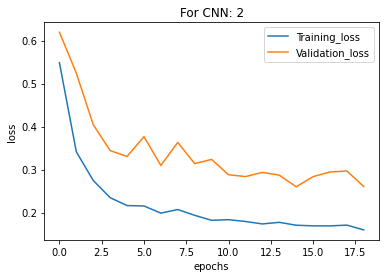

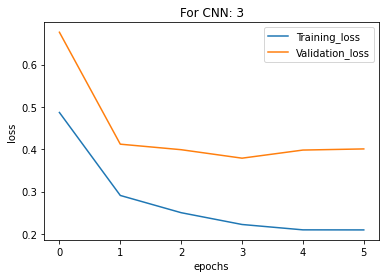

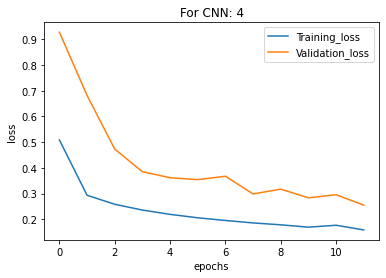

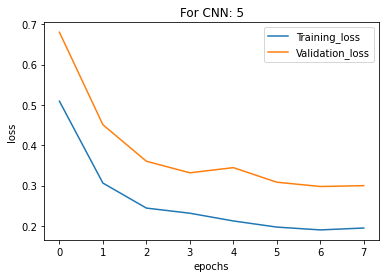

In [30]:
for j in range(nets):
    loss = history[j].history['loss']
    val_loss = history[j].history['val_loss']

    plt.title("For CNN: "+ str(j+1))
    plt.plot(range(len(loss)),loss, label = 'Training_loss')
    plt.plot(range(len(loss)),val_loss, label = 'Validation_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()